In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter, CoxPHFitter, CoxTimeVaryingFitter
from lifelines.statistics import logrank_test
from lifelines.utils import to_long_format, add_covariate_to_timeline, covariates_from_event_matrix

from scipy.stats import chi2, pearsonr, binom_test
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial
import matplotlib.colors

from functools import partial
import os

In [2]:
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"

BIRTH_FIELD = "34-0.0"
SEX_FIELD = "31-0.0" # 0 female, 1 male
CHOLESTEROL_FIELD = "30690-0.0" 
DIABETES_FIELD = "2443-0.0"
CRP_FIELD = "30710-0.0"
HDL_FIELD = "30760-0.0"
SYSTOLIC_BP_FIELD = "4080-0.0"
PLT_FIELD = "30080-0.0"
MPV_FIELD = "30100-0.0"
PCT_FIELD = "30090-0.0"
PDW_FIELD = "30110-0.0"
BMI_FIELD = "21001-0.0"
genetic_PCs = ["22009-0.%d" % i for i in range(1,11)]
SMOKING_FIELD = "20161-0.0"

basics_X_cols = [SMOKING_FIELD] + genetic_PCs # ,BMI_FIELD,DIABETES_FIELD,CHOLESTEROL_FIELD

In [3]:
UKB = pd.read_hdf("%s/UKB.hdf" % export_folder)

In [4]:
UKB.loc[UKB[SMOKING_FIELD].isnull(),SMOKING_FIELD] = 0.
UKB.loc[UKB[DIABETES_FIELD].isnull(),DIABETES_FIELD] = 0.
UKB.loc[UKB[DIABETES_FIELD] < 0,DIABETES_FIELD] = 0.
UKB[DIABETES_FIELD] = UKB[DIABETES_FIELD].astype(int)
UKB.loc[UKB[BMI_FIELD].isnull(),BMI_FIELD] = UKB.loc[~UKB[BMI_FIELD].isnull(),BMI_FIELD].mean()
UKB.loc[UKB[CHOLESTEROL_FIELD].isnull(),CHOLESTEROL_FIELD] = UKB.loc[~UKB[CHOLESTEROL_FIELD].isnull(),CHOLESTEROL_FIELD].mean()

In [5]:
UKB[DIABETES_FIELD].value_counts()

0    365593
1     18466
Name: 2443-0.0, dtype: int64

In [6]:
UKB[basics_X_cols].head(3)

,20161-0.0,22009-0.1,22009-0.2,22009-0.3,22009-0.4,22009-0.5,22009-0.6,22009-0.7,22009-0.8,22009-0.9,22009-0.10
eid,,,,,,,,,,,
1000011,0.0,-13.4848,1.06092,-3.047350,2.22877,-6.06503,-3.956770,0.877139,-0.901110,-1.835710,-0.401581
1000026,0.0,-13.2959,4.07063,0.425932,4.78868,1.00465,-0.544458,-2.408010,-1.404980,1.165280,0.278346
1000032,0.0,-15.4969,5.15194,-2.708700,4.22973,5.24573,-1.585010,2.513620,-0.968024,-0.302836,-1.710030


In [7]:
UKB.sample(3)

,31-0.0,34-0.0,845-0.0,2139-0.0,2217-0.0,2443-0.0,2714-0.0,2754-0.0,2764-0.0,2794-0.0,...,DRUG_228,DRUG_229,DRUG_230,DRUG_231,DRUG_232,DRUG_233,DRUG_234,DRUG_235,DRUG_236,AGE
eid,,,,,,,,,,,,,,,,,,,,,
3959904,1.0,1940-01-01,15.0,NaN,43.0,0,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,70.1
4615702,0.0,1942-01-01,15.0,19.0,15.0,0,11.0,27.0,34.0,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,77.0
1803156,0.0,1963-01-01,16.0,17.0,NaN,0,15.0,24.0,29.0,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,56.0


In [8]:
betas = pd.read_hdf("%s/UKB_causal_SNPS_genotypes/betas.hdf" % export_folder,key="scores")

In [9]:
betas

SNP,rs12566888,rs1434282,rs41315846,rs13412535,rs78909033,rs1354034,rs13067286,rs76445378,rs922140,rs3819288,...,rs61751937,rs10886430,rs7123827,rs11553699,rs61978213,rs59001897,rs8057254,rs12445050,rs11078475,rs1654425
ADP_pred,0.1248,0.069544,0.049249,0.057557,0.069758,0.074894,-0.047616,0.16771,-0.068151,0.083528,...,-0.169112,-0.068886,-0.043878,-0.13446,-0.124011,-0.055161,-0.055509,-0.107511,-0.045222,-0.091918
ALLELE1,G,C,T,G,G,T,G,C,A,T,...,G,A,A,A,G,T,T,C,T,T
COUNTED,T,T,C,A,A,C,A,T,G,C,...,C,G,C,G,A,A,A,T,C,C


In [10]:
scores = pd.read_hdf("%s/scores_table.hdf" % export_folder,key="scores")

In [11]:
scores.sample(3)

,INTERVAL_score,ADP_score,best_pval_score,best_pval_score_homogenous,PLT_score,MPV_score,PCT_score,PDW_score
IID,,,,,,,,
2025658,-0.170673,-0.314037,1.085692,0.078109,0.006166,-0.036953,-0.000900,-0.005699
4174134,-0.308132,0.392349,1.292193,0.232037,0.033844,-0.042514,0.010710,-0.029884
5610812,-0.205923,-0.649176,0.657000,-0.023130,0.023573,-0.049273,0.006821,-0.004983


In [12]:
X = pd.merge(UKB, scores, left_index=True,right_index=True,how="inner")

In [13]:
X[CRP_FIELD] = X[CRP_FIELD].fillna(X[CRP_FIELD].mean())
X[SYSTOLIC_BP_FIELD] = X[SYSTOLIC_BP_FIELD].fillna(X[SYSTOLIC_BP_FIELD].mean())

In [14]:
assert X[basics_X_cols].isnull().sum(axis=0).sum() == 0

In [15]:
# Done loading X

In [16]:
#all_ICD10_events = pd.read_csv("%s/ICD10_events.csv" % export_folder,index_col=0)
#all_ICD10_events["Date"] = pd.to_datetime(all_ICD10_events.Date)
#print(all_ICD10_events.shape)

In [17]:
X.shape

(384059, 1947)

In [18]:
ICD10_sec_desc = pd.read_csv("%s/coding19.tsv" % export_folder, sep="\t").set_index("coding")["meaning"].to_dict()

In [19]:
coag_related_codes = ["I21","I25","I26","I80","H40"]
ICD10_sec_desc["meta_coag"] = "Coag ICD10 code (DVT, CAD, PE, MI, glaucoma)"
for code in coag_related_codes:
    print(ICD10_sec_desc[code])

I21 Acute myocardial infarction
I25 Chronic ischaemic heart disease
I26 Pulmonary embolism
I80 Phlebitis and thrombophlebitis
H40 Glaucoma


In [20]:
all_ICD10_events = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/phenotypes.csv")
all_ICD10_events = all_ICD10_events.loc[all_ICD10_events.pheno_type == "ICD10-UKB"]
all_ICD10_events = all_ICD10_events.rename(columns={"pheno_id":"code","age":"AGE_AT_EVENT","sample_id":"ID"})
all_ICD10_events = all_ICD10_events[["code","AGE_AT_EVENT","ID"]]

print(all_ICD10_events.shape)

all_ICD10_events_shortcodes = all_ICD10_events.copy()
all_ICD10_events_shortcodes["code"] = all_ICD10_events_shortcodes["code"].str.split(".",expand=True)[0]
all_ICD10_events_shortcodes = all_ICD10_events_shortcodes.loc[~all_ICD10_events_shortcodes.code.isin(all_ICD10_events.code.unique().tolist())]
print(all_ICD10_events.code.nunique())
print(all_ICD10_events_shortcodes.code.nunique())
all_ICD10_events = pd.concat([all_ICD10_events,all_ICD10_events_shortcodes],axis=0)
print(all_ICD10_events.code.nunique())

print(all_ICD10_events.shape)

/home/hv270/platelets/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(5989813, 3)
12222
1655
13877
(11008703, 3)


In [21]:
diabetes_events = all_ICD10_events.loc[all_ICD10_events.code.str.contains("E08") |\
                                       all_ICD10_events.code.str.contains("E09") |\
                                       all_ICD10_events.code.str.contains("E10") |\
                                       all_ICD10_events.code.str.contains("E11") |\
                                       all_ICD10_events.code.str.contains("E12") |\
                                       all_ICD10_events.code.str.contains("E13")]

In [22]:
first_diabete = diabetes_events.groupby("ID")[["AGE_AT_EVENT"]].min().reset_index()\
    .rename(columns={"AGE_AT_EVENT":"AGE_AT_DIABETES"})

In [23]:
diabetes_IDs = first_diabete.ID.tolist()
diabetes_codes = diabetes_events.code.unique().tolist()

In [24]:
X = pd.merge(X,first_diabete,left_index=True,right_on="ID",how="left").set_index("ID")
X["AGE_AT_DIABETES"].fillna(np.inf,inplace=True)

In [25]:
meta_coag_events = all_ICD10_events.loc[all_ICD10_events.code.isin(coag_related_codes)].groupby("ID").agg({"AGE_AT_EVENT":"min"}).reset_index()
meta_coag_events["code"] = "meta_coag"
meta_coag_events = meta_coag_events[["code","AGE_AT_EVENT","ID"]]
all_ICD10_events = pd.concat([all_ICD10_events,meta_coag_events],axis=0)
meta_coag_events.head()

,code,AGE_AT_EVENT,ID
0,meta_coag,62.0,1000044
1,meta_coag,60.0,1000150
2,meta_coag,74.0,1000195
3,meta_coag,65.0,1000252
4,meta_coag,58.0,1000289


In [26]:
X["SMOKING_BOOL"] = (X[SMOKING_FIELD] >= 3)*1

In [27]:
X["SMOKING_RATE"] = np.clip((X[SMOKING_FIELD] - 15)/X["AGE"],a_min=0,a_max=2)

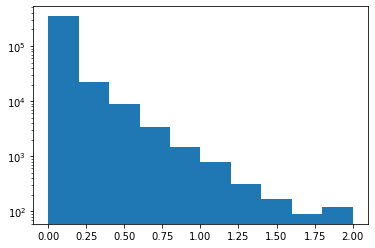

In [28]:
plt.hist(X["SMOKING_RATE"])
plt.yscale("log")

In [29]:
X[CRP_FIELD] = np.clip(X[CRP_FIELD],a_min=0,a_max=10)

In [30]:
X["AGE_int"] = np.floor(X["AGE"])

(array([3.24000e+02, 4.49850e+04, 1.47161e+05, 1.00747e+05, 3.45850e+04,
        7.62200e+03, 1.25400e+03, 2.38000e+02, 3.00000e+01, 1.00000e+01]),
 array([0.219 , 0.6372, 1.0554, 1.4736, 1.8918, 2.31  , 2.7282, 3.1464,
        3.5646, 3.9828, 4.401 ]),
 <a list of 10 Patch objects>)

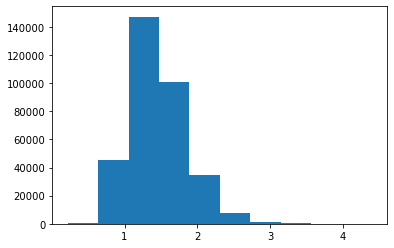

In [31]:
plt.hist(X[HDL_FIELD])

In [32]:
# Doing the PH test, we found that smoking and cholesterol are age-related and should thus be used more as strata
for c in ["SMOKING_RATE",CHOLESTEROL_FIELD,HDL_FIELD,CRP_FIELD,SYSTOLIC_BP_FIELD]:
    X[c].fillna(X[c].median(),inplace=True)
X["SMOKING_RATE_bin"] = pd.cut(X["SMOKING_RATE"],bins=[-0.001,0.0001,.5,2.01],labels=False)
X["CHOLESTEROL_bin"] = pd.qcut(X[CHOLESTEROL_FIELD],4,labels=False)
X["HDL_bin"] = pd.qcut(X[HDL_FIELD],3,labels=False)
X["CRP_bin"] = pd.qcut(X[CRP_FIELD],4,labels=False)
X["SYSTOLIC_BP_bin"] = pd.qcut(X[SYSTOLIC_BP_FIELD],3,labels=False)

In [33]:
2*3*4*3*4*3

864

In [34]:
sysmex_covars = ["MPV_score","PLT_score","PDW_score","PCT_score"]  # ,"IPF_score"
pheno_cols_to_norm = [c for c in list(scores.columns) if c not in sysmex_covars]
cols_to_normalize = sysmex_covars + pheno_cols_to_norm #+ [SMOKING_FIELD]
X[cols_to_normalize] -= X[cols_to_normalize].mean(axis=0)
X[cols_to_normalize] /= X[cols_to_normalize].std(axis=0)

In [35]:
# Create decomposition of sysmex covariates so that they don't correlate
pc_covars_cols = ["sysmex_PC_%d" % i for i in range(len(sysmex_covars))]
pca = PCA()
X[pc_covars_cols] = pca.fit_transform(X[sysmex_covars])
X[pc_covars_cols] -= X[pc_covars_cols].mean(axis=0)
X[pc_covars_cols] /= X[pc_covars_cols].std(axis=0)

In [36]:
all_codes = all_ICD10_events.code.unique().tolist()

In [37]:
first_thrombosis = all_ICD10_events_shortcodes.loc[
    all_ICD10_events_shortcodes.code.isin(["I20","I21","I22","I23","I24","I25","I26","I80","I81","I82"])
].sort_values("AGE_AT_EVENT").groupby("ID").first().rename(columns={"AGE_AT_EVENT":"AGE_COAG_EVENT"})
print(first_thrombosis.shape)
#first_thrombosis["AGE_COAG_EVENT"] -= 1 # Pour être sûr que si jamais la purpura et la coagulation arrivent la même année, on aura quand même ici la coag avant
first_thrombosis.head()

(69222, 2)


,code,AGE_COAG_EVENT
ID,,
1000044,I20,62.0
1000150,I25,60.0
1000195,I25,74.0
1000252,I25,65.0
1000289,I80,58.0


In [38]:
if "AGE_COAG_EVENT" in X.columns:
    del X["AGE_COAG_EVENT"]
X = pd.merge(X, first_thrombosis[["AGE_COAG_EVENT"]],left_index=True,right_index=True,how="left")
X["AGE_COAG_EVENT"].fillna(np.inf,inplace=True)

In [39]:
has_coag = X["AGE_COAG_EVENT"] < np.inf
print("%d percent of people who have coag have it at the age of measurement" % 
      (100*(X.loc[has_coag,"AGE"] <= X.loc[has_coag,"AGE_COAG_EVENT"]).mean())
     )
X.loc[has_coag,"AGE"] = X.loc[has_coag,["AGE","AGE_COAG_EVENT"]].max(axis=1)

15 percent of people who have coag have it at the age of measurement


In [40]:
drug_columns = pd.read_csv("%s/drug_columns.hdf" % export_folder,index_col=0)

In [41]:
X["AGE_DRUG"] = ((X["DRUG_236"] - X[BIRTH_FIELD]).dt.days // 365).fillna(np.inf)

In [42]:
X["AGE_DRUG_OR_COAG"] = X[["AGE_DRUG","AGE_COAG_EVENT"]].min(axis=1)

In [43]:
X = X.loc[X[[PLT_FIELD, MPV_FIELD, PCT_FIELD, PDW_FIELD]].isnull().sum(axis=1) == 0]

In [44]:
covariates_sets = {
    #"none":[],
    "PLT-MPV-PCT-PDW":[PLT_FIELD, MPV_FIELD, PCT_FIELD, PDW_FIELD],
}
T_cols = {
    "default":"AGE",
    #"first_anticoag_or_drug":"AGE_DRUG_OR_COAG"
} # End of inclusion
add_more_sets = False
if add_more_sets:    
    for c in X.columns:
        if c[:4] == "DRUG":
            drug_name = drug_columns.loc[drug_columns.drug_ID == c,"drug"].iloc[0]
            if "(any)" in drug_name:
                covariates_sets[drug_name] = [c]
variable_covariates_to_simplify = []
for d, cols in covariates_sets.items():
    variable_covariates_to_simplify += [c for c in cols if "DRUG" in c]

In [45]:
all_covariates_ = []
for b in covariates_sets:
    all_covariates_ = all_covariates_ + covariates_sets[b]

In [46]:
strata_bins = ["SMOKING_RATE_bin","CRP_bin","CHOLESTEROL_bin","HDL_bin","SYSTOLIC_BP_bin"]

In [47]:
# mandatory_cols : columns needed for any CoxPH
mandatory_cols = [BIRTH_FIELD,SEX_FIELD,"AGE","AGE_AT_DIABETES","AGE_COAG_EVENT","AGE_DRUG","AGE_DRUG_OR_COAG"] + strata_bins

# Functions

In [48]:
# Refaire marcher dans le cas constant
# Et faire marcher si possible dans le cas variable

min_n_cases = 1000

def do_cox_test(args, variables_to_test, IDs_to_include=None):
    
    code, events = args
    n_cases = events.shape[0]
    desc = ICD10_sec_desc["".join(code.split("."))]
    if n_cases <= min_n_cases: 
        print("n_cases = %d <= %d"% (n_cases,min_n_cases))
        return None
    
    res = {
        "p_val":[],
        "desc":[],
        "log_HR":[],
        "code":[],
        "covariates":[],
        "n_cases":[],
        "include_until":[],
    }
    
    for t_col_name, t_col in T_cols.items():
        X_ = pd.merge(X[mandatory_cols + list(set([c for c in all_covariates_ if c in X.columns] + pc_covars_cols + pheno_cols))],
                      events,left_index=True,right_on="ID",how="left").copy()
        X_ = X_.loc[X_[mandatory_cols].isnull().sum(axis=1) == 0]
        if IDs_to_include is not None:
            X_ = X_.loc[X_.ID.isin(IDs_to_include)]
    
        # Make sure that events really happen before the age at measurement.
        # If they happen more than 1 year before AGE, it's fine, there will be no 'rounding' effect due to int ages
        has_event = ~X_.AGE_AT_EVENT.isnull()
        #print("Mean age before correction %.2f" % X_["AGE"].mean())
        #X_.loc[has_event, "AGE"] = X_.loc[has_event,["AGE","AGE_AT_EVENT"]].max(axis=1)
        X_.loc[X_[t_col] < np.inf, "AGE"] = X_.loc[X_[t_col] < np.inf,["AGE",t_col,"AGE_AT_EVENT"]].max(axis=1)
        #print("Mean age after correction %.2f" % X_["AGE"].mean())
    
        #print("%d peole" % X_.shape[0])
        X_["T"] = X_[["AGE",t_col,"AGE_AT_EVENT"]].copy().min(axis=1).astype(float)
        #print("mean age %.2f" % X_["AGE"].mean())
        #print("mean time of measurement %.2f" % X_["T"].mean())
        #print("mean time of event %.2f" % X_.loc[has_event,"T"].mean())
        #print("%d cases" % has_event.sum())
        X_["EVENT"] = has_event
        if t_col != "AGE":
            #X_["EVENT"] = X_["EVENT"] & (X_["AGE_AT_EVENT"] < X_[t_col])
            #X_.loc[X_.EVENT,"EVENT"]
            X_.loc[X_["T"] < X_["AGE_AT_EVENT"],"EVENT"] = False
            X_.loc[X_[t_col] <= X_["AGE_AT_EVENT"],"EVENT"] = False
        
        #print("For those who have the event %s - %s" % ("T","AGE_AT_EVENT"))
        #print((X_.loc[X_.EVENT,"T"] - X_.loc[X_.EVENT,"AGE_AT_EVENT"]).value_counts().head())
        
        #print("For those who have the event and t_col %s - %s" % (t_col,"AGE_AT_EVENT"))
        #print((X_.loc[X_.EVENT & (X_[t_col] < np.inf),t_col] - X_.loc[X_.EVENT & (X_[t_col] < np.inf),"AGE_AT_EVENT"]).value_counts().head())
        
        
        
        #print("%d cases before %s" % (X_["EVENT"].sum(),t_col))
        X_["EVENT"] = X_["EVENT"]*1
        X_["HAD_DIABETES_BEFORE"] = X_["AGE_AT_DIABETES"] < X_["T"]
        X_["HAD_COAG_BEFORE"] = X_["AGE_COAG_EVENT"] < X_["T"]
        
        #print("T = %s, mean age at event = %.2f" % (t_col_name, X_.loc[has_event,"T"].mean()))
        del X_["AGE_AT_DIABETES"]
        del X_["AGE_COAG_EVENT"]
        assert X_["T"].isnull().sum() == 0
        
        # Re-do this for columns in variable_covariates_to_simplify
        # First convert to age

        tv_covariates = []
        fixed_covariates = []

        for c in all_covariates_:
            if "M" in X_[c].dtype.kind:
                # Date -> age
                X_[c] = ((X_[c] - X_[BIRTH_FIELD]).dt.days // 365).astype(float)
                X_[c].fillna(np.inf, inplace=True)
                assert X_[c].min() >= 0, X_[c].min()
                if c in variable_covariates_to_simplify:
                    # In this case, we only look at whether the event occured before or after the covariate event.
                    X_[c] = X_[c] < X_["T"]
                    fixed_covariates.append(c)
                else:
                    tv_covariates.append(c)
            else:
                fixed_covariates.append(c)

        #print("%d tv covariates and %d fixed" % (len(tv_covariates), len(fixed_covariates)))


        # find if unisex
        n_cases = X_.EVENT.sum()
        valid_sexes = X_.loc[X_["EVENT"] > 0,SEX_FIELD].value_counts()
        valid_sexes = valid_sexes.loc[valid_sexes > (n_cases / 50)].index.tolist()
        unisex = len(valid_sexes) == 1
        if unisex:
            desc += " (unisex)"

        # Define people to include and strata
        to_include = X_[SEX_FIELD].isin(valid_sexes)
        strata = [SEX_FIELD] if not unisex else []
        strata += strata_bins

        pen_args = {"penalizer":0.0,"l1_ratio":1.}
        fit_args = {"duration_col":"duration","event_col":"EVENT","strata":strata,
                    "show_progress":False,"step_size":.5}

        X_ = X_.loc[to_include]
        X_ = X_.rename(columns={"T":"duration"})
        n_cases = X_.EVENT.sum()
        if n_cases <= min_n_cases: 
            continue

        basics = ["ID","duration","EVENT"] + strata
        all_cols_to_include = basics + variables_to_test + all_covariates_ 

        df = X_[all_cols_to_include]

        base_df = df[basics + variables_to_test + fixed_covariates].reset_index(drop=True)
        need_time_varying = len(tv_covariates) > 0
        if need_time_varying:
            print("Need time varying things")
            cv = covariates_from_event_matrix(df[["ID"] + tv_covariates], id_col="ID")
            base_df = to_long_format(base_df,duration_col="duration")
            base_df = add_covariate_to_timeline(base_df, cv, duration_col="duration", id_col="ID", event_col="EVENT")
        df_to_fit = base_df.set_index("ID")
        
         

        for covars_group, covars in covariates_sets.items():



            if need_time_varying:
                aft1 = CoxTimeVaryingFitter(penalizer=0.1)
                cols_to_include_1 = strata + covars + ["ID","EVENT","stop","start"]

            else:
                aft1 = CoxPHFitter(**pen_args)
                cols_to_include_1 = basics + covars
            cols_to_include_1.remove("ID")

            #print("Fitting model with covars %s" % covars)
            aft1.fit(df_to_fit[cols_to_include_1], **fit_args) 

            #aft1.print_summary()

            for target in variables_to_test:
                cols_to_include_2 = cols_to_include_1 + [target]
                aft2 = CoxPHFitter(**pen_args)
                #print("Fitting model on %s" % target)
                aft2.fit(df_to_fit[cols_to_include_2], **fit_args)

                LL_without = aft1.log_likelihood_
                LL_with = aft2.log_likelihood_
                Delta_LL = LL_with-LL_without
                p_val = 1.-chi2(1).cdf(2*Delta_LL)

                HR = aft2.hazard_ratios_[target]

                description = ""
                description += "| %s \t| %s : %.2f\t" % (target, covars_group,-np.log10(p_val))
                description += "%d cases \t %s \t %s" % (n_cases, code, desc)

                if p_val < 1e-3:

                    print("==========================")
                    print(description)
                    print("==========================")
                    aft2.print_summary()
                
                res["p_val"].append(p_val)
                res["log_HR"].append(np.log(HR))
                res["desc"].append(desc)
                res["code"].append(code)
                res["covariates"].append(covars_group)
                res["n_cases"].append(n_cases)
                res["include_until"].append(t_col_name)
    
    return res

# Test SNPs separately

In [53]:
#pheno_cols = [c for c in list(scores.columns) if c not in sysmex_covars]
pheno_cols = ["best_pval_score_homogenous"]
for c in pheno_cols:
    assert c in scores.columns

In [54]:
run_name = "sysmex_covars"
run_dir = "/home/hv270/cox/%s" % run_name
force_recompute = True
if not os.path.exists(run_dir):
    os.mkdir(run_dir)


code_file = lambda code: "%s/%s.csv" % (run_dir, code)

n_events = all_ICD10_events.code.value_counts()
large_events = n_events.loc[n_events >= min_n_cases].index.tolist()
cond = all_ICD10_events.code.isin(large_events) & ~all_ICD10_events.code.isin(diabetes_codes)

already_processed_codes = [c for c in all_ICD10_events.loc[cond].code.unique().tolist() if os.path.exists(code_file(c))]
print("%d already processed codes" % len(already_processed_codes))
if not force_recompute:
    cond = cond & ~all_ICD10_events.code.isin(already_processed_codes)

#codes_to_focus_on = ["D69","I26","I21","I80","I25"] # Thrombosis
codes_to_focus_on = []
#codes_to_focus_on = ["I26","I26.9","Z86.7","I21","I80","D69","meta_coag","D69.6","I25","M72.04","I51","T43"]
if len(codes_to_focus_on) > 0:
    cond = cond & all_ICD10_events.code.isin(codes_to_focus_on)
n_codes_to_process = all_ICD10_events.loc[cond].code.nunique()
print("%d codes to process" % n_codes_to_process)

NameError: name 'min_n_cases' is not defined

In [51]:
do_cox_test_pheno = partial(do_cox_test,variables_to_test=pheno_cols)#,IDs_to_include = IDs_no_anti_coag

In [52]:
#results = []
#for arg in all_ICD10_events.loc[cond].groupby("code"):
#    print(arg[0])
#    results.append(do_cox_test_pheno(arg))

In [53]:
#results_df = pd.concat([pd.DataFrame.from_dict(d) for d in results],axis=0)

In [54]:
p = Pool(16)

for res in tqdm(p.imap_unordered(do_cox_test_pheno, all_ICD10_events.loc[cond].groupby("code")),
              total=n_codes_to_process):
    if res is None: continue
    df = pd.DataFrame.from_dict(res)
    code = res["code"][0]
    df.to_csv(code_file(code))
p.close()
p.join()

  2%|▏         | 34/1435 [08:16<42:33,  1.82s/it]   

| best_pval_score_homogenous 	| PLT-MPV-PCT-PDW : 3.63	1579 cases 	 C16 	 C16 Malignant neoplasm of stomach


<lifelines.CoxPHFitter: fitted with 384667 total observations, 383088 right-censored observations>
             duration col = 'duration'
                event col = 'EVENT'
                   strata = ['31-0.0', 'SMOKING_RATE_bin', 'CRP_bin', 'CHOLESTEROL_bin', 'HDL_bin', 'SYSTOLIC_BP_bin']
      baseline estimation = breslow
   number of observations = 384667
number of events observed = 1579
   partial log-likelihood = -9077.22
         time fit was run = 2022-10-17 09:50:07 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
30080-0.0                    0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
30100-0.0                   -0.05       0.95       0.09            -0.23             0.12                 0.79                 1.13
30090-0.0                    0.45       1.57       3.77            -6.94             7.84                 0.00              2538.75
30110-0.0                   -0.02       0.98       0.06            -0.13             0.09                 0.88                 1.09
best_pval_score_homogenous   0.09       1.10       0.03             0.04             0.14                 1.04                 1.15

                               z      p   -log2(p)
covariate                                         
30080-0.0                   0.33   0.74       0.43
30100-0.0                  -0.59   0.55       0.86
30090-0.0                   0.12   0.90       0.14
30110-0.0                  -0.38   0.70       0.51
best_pval_score_homogenous  3.68 <0.005      12.09
---
Concordance = 0.50
Partial AIC = 18164.43
log-likelihood ratio test = 32.73 on 5 df
-log2(p) of ll-ratio test = 17.84

 25%|██▍       | 356/1435 [1:11:46<5:09:02, 17.19s/it]

| best_pval_score_homogenous 	| PLT-MPV-PCT-PDW : 5.25	14198 cases 	 I21 	 I21 Acute myocardial infarction


<lifelines.CoxPHFitter: fitted with 385810 total observations, 371612 right-censored observations>
             duration col = 'duration'
                event col = 'EVENT'
                   strata = ['31-0.0', 'SMOKING_RATE_bin', 'CRP_bin', 'CHOLESTEROL_bin', 'HDL_bin', 'SYSTOLIC_BP_bin']
      baseline estimation = breslow
   number of observations = 385810
number of events observed = 14198
   partial log-likelihood = -83874.20
         time fit was run = 2022-10-17 10:54:39 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
30080-0.0                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
30100-0.0                    0.06       1.07       0.03             0.01             0.12                 1.01                 1.13
30090-0.0                   -0.66       0.52       1.22            -3.05             1.73                 0.05                 5.66
30110-0.0                   -0.03       0.97       0.02            -0.07             0.00                 0.93                 1.00
best_pval_score_homogenous   0.04       1.04       0.01             0.02             0.06                 1.02                 1.06

                               z      p   -log2(p)
covariate                                         
30080-0.0                   0.95   0.34       1.55
30100-0.0                   2.21   0.03       5.22
30090-0.0                  -0.54   0.59       0.76
30110-0.0                  -1.87   0.06       4.03
best_pval_score_homogenous  4.54 <0.005      17.46
---
Concordance = 0.50
Partial AIC = 167758.39
log-likelihood ratio test = 53.88 on 5 df
-log2(p) of ll-ratio test = 32.07

 26%|██▌       | 369/1435 [1:14:37<2:03:35,  6.96s/it]

| best_pval_score_homogenous 	| PLT-MPV-PCT-PDW : 7.25	6942 cases 	 I26 	 I26 Pulmonary embolism


 26%|██▌       | 370/1435 [1:14:39<1:42:20,  5.77s/it]

<lifelines.CoxPHFitter: fitted with 384438 total observations, 377496 right-censored observations>
             duration col = 'duration'
                event col = 'EVENT'
                   strata = ['31-0.0', 'SMOKING_RATE_bin', 'CRP_bin', 'CHOLESTEROL_bin', 'HDL_bin', 'SYSTOLIC_BP_bin']
      baseline estimation = breslow
   number of observations = 384438
number of events observed = 6942
   partial log-likelihood = -40916.21
         time fit was run = 2022-10-17 10:56:36 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
30080-0.0                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
30100-0.0                   -0.00       1.00       0.04            -0.09             0.08                 0.92                 1.08
30090-0.0                    1.79       6.01       1.75            -1.63             5.22                 0.20               184.67
30110-0.0                   -0.02       0.98       0.03            -0.07             0.03                 0.93                 1.03
best_pval_score_homogenous   0.07       1.07       0.01             0.04             0.09                 1.04                 1.09

                               z      p   -log2(p)
covariate                                         
30080-0.0                  -0.32   0.75       0.42
30100-0.0                  -0.09   0.93       0.11
30090-0.0                   1.03   0.30       1.71
30110-0.0                  -0.82   0.41       1.28
best_pval_score_homogenous  5.43 <0.005      24.12
---
Concordance = 0.50
Partial AIC = 81842.42
log-likelihood ratio test = 54.66 on 5 df
-log2(p) of ll-ratio test = 32.60

 26%|██▌       | 371/1435 [1:14:39<1:12:57,  4.11s/it]

| best_pval_score_homogenous 	| PLT-MPV-PCT-PDW : 6.69	6792 cases 	 I26.9 	 I26.9 Pulmonary embolism without mention of acute cor pulmonale


<lifelines.CoxPHFitter: fitted with 384399 total observations, 377607 right-censored observations>
             duration col = 'duration'
                event col = 'EVENT'
                   strata = ['31-0.0', 'SMOKING_RATE_bin', 'CRP_bin', 'CHOLESTEROL_bin', 'HDL_bin', 'SYSTOLIC_BP_bin']
      baseline estimation = breslow
   number of observations = 384399
number of events observed = 6792
   partial log-likelihood = -40092.18
         time fit was run = 2022-10-17 10:56:47 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
30080-0.0                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
30100-0.0                   -0.00       1.00       0.04            -0.09             0.08                 0.92                 1.09
30090-0.0                    1.71       5.55       1.77            -1.75             5.17                 0.17               176.62
30110-0.0                   -0.02       0.98       0.03            -0.07             0.03                 0.93                 1.03
best_pval_score_homogenous   0.06       1.07       0.01             0.04             0.09                 1.04                 1.09

                               z      p   -log2(p)
covariate                                         
30080-0.0                  -0.28   0.78       0.35
30100-0.0                  -0.05   0.96       0.06
30090-0.0                   0.97   0.33       1.59
30110-0.0                  -0.76   0.45       1.15
best_pval_score_homogenous  5.20 <0.005      22.24
---
Concordance = 0.50
Partial AIC = 80194.36
log-likelihood ratio test = 51.19 on 5 df
-log2(p) of ll-ratio test = 30.24

 57%|█████▋    | 823/1435 [2:49:35<2:10:07, 12.76s/it]

| best_pval_score_homogenous 	| PLT-MPV-PCT-PDW : 3.21	1362 cases 	 M71 	 M71 Other bursopathies


<lifelines.CoxPHFitter: fitted with 384086 total observations, 382724 right-censored observations>
             duration col = 'duration'
                event col = 'EVENT'
                   strata = ['31-0.0', 'SMOKING_RATE_bin', 'CRP_bin', 'CHOLESTEROL_bin', 'HDL_bin', 'SYSTOLIC_BP_bin']
      baseline estimation = breslow
   number of observations = 384086
number of events observed = 1362
   partial log-likelihood = -8277.78
         time fit was run = 2022-10-17 12:31:55 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
30080-0.0                   -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
30100-0.0                   -0.10       0.91       0.10            -0.30             0.11                 0.74                 1.11
30090-0.0                    1.13       3.09       4.22            -7.15             9.41                 0.00             12167.88
30110-0.0                   -0.07       0.93       0.06            -0.19             0.05                 0.82                 1.05
best_pval_score_homogenous  -0.09       0.91       0.03            -0.15            -0.04                 0.86                 0.96

                               z      p   -log2(p)
covariate                                         
30080-0.0                  -0.28   0.78       0.37
30100-0.0                  -0.95   0.34       1.55
30090-0.0                   0.27   0.79       0.34
30110-0.0                  -1.17   0.24       2.05
best_pval_score_homogenous -3.42 <0.005      10.66
---
Concordance = 0.50
Partial AIC = 16565.57
log-likelihood ratio test = 26.51 on 5 df
-log2(p) of ll-ratio test = 13.78

 59%|█████▉    | 846/1435 [2:54:11<3:12:01, 19.56s/it]

| best_pval_score_homogenous 	| PLT-MPV-PCT-PDW : 3.98	15583 cases 	 M81 	 M81 Osteoporosis without pathological fracture


<lifelines.CoxPHFitter: fitted with 387059 total observations, 371476 right-censored observations>
             duration col = 'duration'
                event col = 'EVENT'
                   strata = ['31-0.0', 'SMOKING_RATE_bin', 'CRP_bin', 'CHOLESTEROL_bin', 'HDL_bin', 'SYSTOLIC_BP_bin']
      baseline estimation = breslow
   number of observations = 387059
number of events observed = 15583
   partial log-likelihood = -90981.93
         time fit was run = 2022-10-17 12:36:21 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
30080-0.0                    0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
30100-0.0                    0.03       1.03       0.03            -0.02             0.09                 0.98                 1.09
30090-0.0                   -2.56       0.08       1.15            -4.81            -0.31                 0.01                 0.73
30110-0.0                   -0.01       0.99       0.02            -0.05             0.03                 0.95                 1.03
best_pval_score_homogenous   0.03       1.03       0.01             0.02             0.05                 1.02                 1.05

                               z      p   -log2(p)
covariate                                         
30080-0.0                   3.67 <0.005      12.03
30100-0.0                   1.14   0.25       1.98
30090-0.0                  -2.23   0.03       5.29
30110-0.0                  -0.55   0.58       0.79
best_pval_score_homogenous  3.88 <0.005      13.22
---
Concordance = 0.50
Partial AIC = 181973.86
log-likelihood ratio test = 187.89 on 5 df
-log2(p) of ll-ratio test = 126.09

 95%|█████████▌| 1366/1435 [4:26:32<19:04, 16.59s/it]  

| best_pval_score_homogenous 	| PLT-MPV-PCT-PDW : 3.71	111602 cases 	 Z86 	 Z86 Personal history of certain other diseases


<lifelines.CoxPHFitter: fitted with 410259 total observations, 298657 right-censored observations>
             duration col = 'duration'
                event col = 'EVENT'
                   strata = ['31-0.0', 'SMOKING_RATE_bin', 'CRP_bin', 'CHOLESTEROL_bin', 'HDL_bin', 'SYSTOLIC_BP_bin']
      baseline estimation = breslow
   number of observations = 410259
number of events observed = 111602
   partial log-likelihood = -640708.09
         time fit was run = 2022-10-17 14:08:47 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
30080-0.0                    0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
30100-0.0                    0.04       1.04       0.01             0.02             0.06                 1.02                 1.06
30090-0.0                   -0.93       0.39       0.43            -1.77            -0.09                 0.17                 0.91
30110-0.0                    0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
best_pval_score_homogenous   0.01       1.01       0.00             0.01             0.02                 1.01                 1.02

                               z      p   -log2(p)
covariate                                         
30080-0.0                   4.37 <0.005      16.28
30100-0.0                   3.68 <0.005      12.04
30090-0.0                  -2.18   0.03       5.09
30110-0.0                   0.26   0.80       0.32
best_pval_score_homogenous  3.73 <0.005      12.34
---
Concordance = 0.50
Partial AIC = 1281426.19
log-likelihood ratio test = 221.18 on 5 df
-log2(p) of ll-ratio test = 149.75

 96%|█████████▌| 1372/1435 [4:27:35<10:56, 10.42s/it]

| best_pval_score_homogenous 	| PLT-MPV-PCT-PDW : 3.89	27912 cases 	 Z86.7 	 Z86.7 Personal history of diseases of the circulatory system


<lifelines.CoxPHFitter: fitted with 384052 total observations, 356140 right-censored observations>
             duration col = 'duration'
                event col = 'EVENT'
                   strata = ['31-0.0', 'SMOKING_RATE_bin', 'CRP_bin', 'CHOLESTEROL_bin', 'HDL_bin', 'SYSTOLIC_BP_bin']
      baseline estimation = breslow
   number of observations = 384052
number of events observed = 27912
   partial log-likelihood = -163228.73
         time fit was run = 2022-10-17 14:10:09 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
30080-0.0                    0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
30100-0.0                    0.08       1.08       0.02             0.04             0.12                 1.04                 1.12
30090-0.0                   -2.64       0.07       0.86            -4.31            -0.96                 0.01                 0.38
30110-0.0                   -0.02       0.98       0.01            -0.05             0.01                 0.96                 1.01
best_pval_score_homogenous   0.02       1.02       0.01             0.01             0.04                 1.01                 1.04

                               z      p   -log2(p)
covariate                                         
30080-0.0                   3.42 <0.005      10.64
30100-0.0                   3.73 <0.005      12.35
30090-0.0                  -3.08 <0.005       8.91
30110-0.0                  -1.50   0.13       2.91
best_pval_score_homogenous  3.83 <0.005      12.93
---
Concordance = 0.51
Partial AIC = 326467.45
log-likelihood ratio test = 34.68 on 5 df
-log2(p) of ll-ratio test = 19.13

100%|█████████▉| 1434/1435 [4:41:31<00:09,  9.76s/it]

| best_pval_score_homogenous 	| PLT-MPV-PCT-PDW : 3.50	54485 cases 	 meta_coag 	 Coag ICD10 code (DVT, CAD, PE, MI, glaucoma)


<lifelines.CoxPHFitter: fitted with 384052 total observations, 329567 right-censored observations>
             duration col = 'duration'
                event col = 'EVENT'
                   strata = ['31-0.0', 'SMOKING_RATE_bin', 'CRP_bin', 'CHOLESTEROL_bin', 'HDL_bin', 'SYSTOLIC_BP_bin']
      baseline estimation = breslow
   number of observations = 384052
number of events observed = 54485
   partial log-likelihood = -322024.63
         time fit was run = 2022-10-17 14:24:38 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
30080-0.0                    0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
30100-0.0                    0.08       1.09       0.01             0.06             0.11                 1.06                 1.12
30090-0.0                   -2.54       0.08       0.62            -3.76            -1.33                 0.02                 0.26
30110-0.0                   -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
best_pval_score_homogenous   0.02       1.02       0.00             0.01             0.02                 1.01                 1.02

                               z      p   -log2(p)
covariate                                         
30080-0.0                   4.28 <0.005      15.73
30100-0.0                   5.75 <0.005      26.78
30090-0.0                  -4.10 <0.005      14.58
30110-0.0                  -0.91   0.36       1.47
best_pval_score_homogenous  3.60 <0.005      11.64
---
Concordance = 0.51
Partial AIC = 644059.26
log-likelihood ratio test = 70.62 on 5 df
-log2(p) of ll-ratio test = 43.58

100%|██████████| 1435/1435 [4:42:20<00:00, 11.81s/it]


In [55]:
already_processed_codes = [c for c in all_ICD10_events.loc[cond].code.unique().tolist() if os.path.exists(code_file(c))]
print(len(already_processed_codes))

1


In [57]:
dfs = []
for code in set(already_processed_codes):
    f = code_file(code)
    df = pd.read_csv(f,index_col=0)
    dfs.append(df)
cox = pd.concat(dfs,axis=0)
cox.to_csv("%s/cox_results.csv" % run_dir)

In [59]:
cox

,p_val,desc,log_HR,code,covariates,n_cases,include_until
0,0.000313,"Coag ICD10 code (DVT, CAD, PE, MI, glaucoma)",0.015596,meta_coag,PLT-MPV-PCT-PDW,54485,default


In [58]:
cox.sort_values("P").head(10)

KeyError: 'P'

# Various post-analyses

## Some util functions

In [ ]:
def get_desc(code):
    other_mappings = {"I2":"Thrombus (I2X.XX)","I8":"Other venous embolism"}
    key = "".join(code.split("."))
    if key in ICD10_sec_desc:
        return ICD10_sec_desc[key]
    elif key in other_mappings:
        return other_mappings[key]
    else:
        return code

## Compare occurence of two codes

In [ ]:
code1 = "I2"
code2 = "D69"
desc1 = get_desc(code1)
desc2 = get_desc(code2)

events_1 = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code1)].sort_values("AGE_AT_EVENT").groupby("ID").first().reset_index()
events_2 = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code2)].sort_values("AGE_AT_EVENT").groupby("ID").first().reset_index()
IDs_1 = list(set(events_1.ID.tolist()))
IDs_2 = list(set(events_2.ID.tolist()))
IDs_both = list(set(IDs_1).intersection(set(IDs_2)))
events_both = pd.merge(events_1, events_2, left_on="ID",right_on="ID",how="inner", suffixes=("_1","_2"))

X_both_and_drug = X.loc[~X["DRUG_236"].isnull() & X.index.isin(events_both.ID.unique().tolist())].copy()
X_both_and_drug["AGE_DRUG"] = (X_both_and_drug["DRUG_236"] - X_both_and_drug[BIRTH_FIELD]).dt.days / 365
events_both = pd.merge(events_both,X_both_and_drug,how="left",left_on="ID",right_index=True)
n_prescriptions = (~events_both.AGE_DRUG.isnull()).sum()
events_both.loc[events_both["AGE_DRUG"] < events_both["AGE_AT_EVENT_1"],"AGE_DRUG"] = np.nan
events_both.loc[events_both["AGE_DRUG"] > events_both["AGE_AT_EVENT_2"],"AGE_DRUG"] = np.nan

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.hist(events_1["AGE_AT_EVENT"],density=True,bins=20, label="%d people with\n%s" % (events_1.ID.nunique(),desc1),histtype="step")
ax.hist(events_2["AGE_AT_EVENT"],density=True,bins=20, label="%d people with\n%s" % (events_2.ID.nunique(),desc2),histtype="step")
ax.legend()
ax.set_xlabel("Age at occurence")
ax = fig.add_subplot(122)
ax.set_title("%d people with both\n%d had prescription inbetween\n(over %d who had prescription and both codes)" % (
    events_both.shape[0], 
    (~events_both.AGE_DRUG.isnull()).sum(),
    n_prescriptions))
ax.hist(events_both["AGE_AT_EVENT_1"] - events_both["AGE_AT_EVENT_2"],bins=np.arange(-20,22)-.5)
plt.axvline(0,c="red",label="$t_1 = t_2$")
ax.set_xlabel("$t_1 - t_2$ \n1: %s \n2: Age %s" % (desc1,desc2))
ax.legend()
plt.tight_layout()

In [ ]:
binom_test(
    events_both.shape[0], 
    events_1.shape[0], (events_2.shape[0] / X.shape[0]))

## Compare occurence of code VS time of death

In [ ]:
code = "I26"
desc = ICD10_sec_desc["".join(code.split("."))]
events = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code)].sort_values("AGE_AT_EVENT").groupby("ID").first().reset_index()
IDs = events.ID.tolist()
comp = pd.merge(events[["ID","AGE_AT_EVENT"]], X[["AGE"]], how="inner",left_on="ID",right_index=True)
assert comp.ID.nunique() == comp.shape[0]
plt.hist(comp["AGE"]-comp["AGE_AT_EVENT"],bins=np.arange(20)-.5)
plt.xlabel("Time after event")
plt.title("%d people died in the year after\n%s\nOver %d" %(((comp["AGE"] - comp["AGE_AT_EVENT"]).abs() < 1).sum(),desc, comp.shape[0]));
plt.tight_layout();

## Look at people with high score and purpura

In [ ]:
all_ICD10_events.loc[all_ICD10_events.code.str.contains("D69")].code.value_counts()

In [ ]:
purpura_IDs = .ID.unique().tolist()

## Thrombosis / anticoagulants 

(first analysis, with incomplete prescription data)

In [ ]:
thrombosis_codes = [
    #"I26", # Pulmonary embolism
    #"I82", # Other venous embolism
    "I2",
    "I8",
]
anti_coag_codes = ["Z92.1","T45.5","Y44.2"]

IDs_no_thrombosis = X.index.tolist()
for code in thrombosis_codes:
    to_exclude = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code)].ID.unique().tolist()
    IDs_no_thrombosis = list(set(IDs_no_thrombosis).difference(set(to_exclude)))
IDs_thrombosis = X.loc[~X.index.isin(IDs_no_thrombosis)].index.tolist()
print("%d thrombosis patients" % len(IDs_thrombosis))

IDs_no_anti_coag = X.index.tolist()
for code in anti_coag_codes:
    to_exclude = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code)].ID.unique().tolist()
    IDs_no_anti_coag = list(set(IDs_no_anti_coag).difference(set(to_exclude)))
IDs_anticoag = X.loc[~X.index.isin(IDs_no_anti_coag)].index.tolist()
print("%d anti-coag patients" % len(IDs_anticoag))

IDs_purpura = set(X.index.tolist()).intersection(all_ICD10_events.loc[all_ICD10_events.code.str.contains("D69")].ID.tolist())
print("%d patients with purpura" % len(IDs_purpura))

purpura = X.index.isin(IDs_purpura)
thrombosis = X.index.isin(IDs_thrombosis)
anticoag = X.index.isin(IDs_anticoag)

X["anticoagulants-ICD10"] = anticoag
X["purpura"] = purpura
X["thrombosis"] = thrombosis

In [ ]:
drug_col = 'DRUG_236' 
code = "I26"
has_code = "has_%s" % code
has_drug = "has_%s" % drug_col
age_drug_col = "AGE_%s" % drug_col
drug_before_event_col = "%s_before_%s" % (drug_col, code)
X[has_drug] = ~X[drug_col].isnull()
X[age_drug_col] = ((X[drug_col] - X[BIRTH_FIELD]).dt.days / 365)
X.loc[X[age_drug_col].isnull(),age_drug_col] = np.inf
events = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code),["AGE_AT_EVENT","ID"]].groupby("ID").agg({"AGE_AT_EVENT":"min"})
print("%d events recorded" % (~events.AGE_AT_EVENT.isnull()).sum())
comp = pd.merge(
    events, 
    X,
    left_index=True,
    right_index=True, how="right")
#comp = comp.loc[comp[strata_bins].isnull().sum(axis=1) == 0]
comp["T"] = comp["AGE"]
comp[has_code] = ~comp["AGE_AT_EVENT"].isnull()
comp.loc[comp[has_code],"T"] = comp.loc[comp[has_code],"AGE_AT_EVENT"]
comp[drug_before_event_col] = (comp[age_drug_col] <= comp["T"])

In [ ]:
print("Took drug %d" % comp[has_drug].sum())

In [ ]:
print("Had the code %d" % comp[has_code].sum()) 
print("Took drug before now %d" % comp[drug_before_event_col].sum())
print("Took drug before code %d" % (comp[drug_before_event_col] & comp[has_code]).sum())

In [ ]:
drug_and_event = comp[has_code] & comp[has_drug]
desc = ICD10_sec_desc["".join(code.split("."))]
plt.title("%d people with \nprescription (over %d) and \n%s (over %d)" % (drug_and_event.sum(), comp[has_drug].sum(), desc,comp[has_code].sum()))
plt.scatter(comp.loc[drug_and_event,age_drug_col], comp.loc[drug_and_event,"AGE_AT_EVENT"],s=1)
plt.xlabel("Age at prescription")
plt.ylabel("Age at %s" % desc)
plt.plot([40,80],[40,80],c="red",ls=":")

In [ ]:
G = comp[["best_pval_score_homogenous",has_code, drug_before_event_col]].copy()

G["score_bin"] = pd.qcut(G["best_pval_score_homogenous"],[0.,0.05,0.3,0.7,0.95,1.],labels=["v_low","low","medium","high","v_high"])
G["score_bin_int"] = pd.qcut(G["best_pval_score_homogenous"],[0.,0.05,0.3,0.7,0.95,1.],labels=[0,1,2,3,4])
print(pearsonr(G[drug_before_event_col],G["best_pval_score_homogenous"]))
print(pearsonr(G[has_code],G["best_pval_score_homogenous"]))


drug_column = drug_before_event_col
H = G.groupby(["score_bin",drug_column]).agg({has_code:"sum","score_bin_int":"count"}).reset_index().rename(columns={"score_bin_int":"# participants"})
H = H.pivot_table(index="score_bin",columns=drug_column,values=[has_code,"# participants"])
H["has_drug (%)"] = 100*H[("# participants",True)] / (H[("# participants",True)] + H[("# participants",False)])
H["risk_without_drug (%)"] = 100*(H[(has_code,False)] / H[("# participants",False)])
H["risk_with_drug (%)"] = 100*(H[(has_code,True)] / H[("# participants",True)])
H["risk_increase"] = H["risk_with_drug (%)"] / H["risk_without_drug (%)"]

H

## Analyze Cox Results (scores)

In [ ]:
# run_name = "BGEN_SNPs"
# run_name = "BGEN_SNPs_no_covars"
# run_name = "BGEN_SNPs_no_covars_pfc_scores"
# run_name = "pfc_score_INTERVAL_hits_w_replacement"
# run_name = "test_no_save"
run_name = "test_all_strata"
run_dir = "/home/hv270/cox/%s" % run_name

In [ ]:
cox = pd.read_csv("%s/cox_results.csv" % run_dir,index_col=0)

In [ ]:
code_roots = cox["code"].str.split(".",expand=True)[0].unique().tolist()
n_indep_codes = len(code_roots)
p_threshold = 0.05 / n_indep_codes
cox["significative"] = cox.P < p_threshold

In [ ]:
n_indep_codes

In [ ]:
cox.sort_values("P").head(15)

In [ ]:
#cox.loc[cox.significative].to_csv("/home/hv270/cox_results.csv")

In [ ]:
cox_primary = cox.loc[~cox.code.str.contains(".",regex=False)]
cox_primary = cox_primary.loc[cox_primary.SNP == "best_pval_score_homogenous"]
epsilon = np.logspace(-np.log10(cox_primary.shape[0]-3),0,250,endpoint=True)[::-1] # 1 -> 1e-5
plt.scatter(-np.log10(epsilon), [-np.log10(cox_primary.P.quantile(e)) for e in epsilon],s=10)
plt.plot([0,4],[0,4],c="red")
plt.ylabel("$-\\log_{10}$ of $\\epsilon$-quantile of P-values\nin Cox Regression")
plt.xlabel("$\\log_{10}(1/\\epsilon)$")

In [ ]:
cox_primary.sort_values("P")

In [ ]:
P_thresh = 0.05 / cox_primary.shape[0]

In [ ]:
P_thresh

In [ ]:
cox_primary.loc[cox_primary.P < P_thresh].sort_values("P")

## Analyze Cox Results (per SNPs)

In [ ]:
# run_name = "BGEN_SNPs"
run_name = "BGEN_SNPs_no_covars"
run_dir = "/home/hv270/cox/%s" % run_name

In [ ]:
gwas_results = pd.read_csv("/home/hv270/sysmex2pf/GWAS_table.csv",index_col=0)
cox = pd.read_csv("%s/cox_results.csv" % run_dir,index_col=0)
cox = cox.merge(gwas_results[["SNP","SYMBOL","BETA"]],left_on="SNP",right_on="SNP",how="left")

code_roots = cox["code"].str.split(".",expand=True)[0].unique().tolist()
n_indep_codes = len(code_roots)
print("indep codes : %d " % n_indep_codes)

n_SNPs = gwas_results.shape[0]
threshold_P = 0.05 / (n_SNPs*(n_indep_codes+1))

cox["significant_all"] = cox.P < threshold_P
cox["significant_1"] = cox.P < threshold_P * n_SNPs
cox["good"] = cox.P < threshold_P * 10


print("significance threshold : %.2e " % threshold_P)

In [ ]:
cox.loc[cox.significant_all].sort_values("P")

In [ ]:
cox.sort_values("P").groupby(["SNP"]).first().reset_index().sort_values("P")

In [ ]:
cox.sort_values("P").groupby(["code"]).first().reset_index().sort_values("P").head(30)

## QQ plot

In [ ]:
epsilon = np.logspace(-np.log10(cox.shape[0]-4),0,50,endpoint=True)[::-1] # 1 -> 1e-5
plt.scatter(-np.log10(epsilon), [-np.log10(cox.P.quantile(e)) for e in epsilon],s=10)
plt.plot([0,4],[0,4],c="red")
plt.ylabel("$-\\log_{10}$ of $\\epsilon$-quantile of P-values\nin Cox Regression")
plt.xlabel("$\\log_{10}(1/\\epsilon)$")

## Compare betas and lambdas

In [ ]:
comp = pd.merge(cox, gwas_results[["SNP"]], left_on="SNP",right_on="SNP")
#comp = comp.loc[~comp.SNP.isin(["rs3819288"])] # Remove HLA-B

In [ ]:
pearson_rho = lambda x : pearsonr(x["BETA"],x["lambda"])[0]
pearson_p = lambda x : pearsonr(x["BETA"],x["lambda"])[1]
spearman_rho = lambda x : spearmanr(x["BETA"],x["lambda"])[0]
spearman_p   = lambda x : spearmanr(x["BETA"],x["lambda"])[1]

In [ ]:
threshold_code = 0.05/n_indep_codes
print(threshold_code)

In [ ]:
good_codes = comp.loc[comp.P < threshold_code].code.unique().tolist()

In [ ]:
from scipy.stats import spearmanr
gb = comp.loc[comp.code.isin(good_codes)].groupby("code")
corr_by_code = gb.agg({"desc":"first"})
corr_by_code["pearson_rho"] = gb.apply(pearson_rho)
corr_by_code["pearson_p"]   = gb.apply(pearson_p)

In [ ]:
corr_by_code.loc[corr_by_code["pearson_p"] < 0.05/n_indep_codes]

In [ ]:
corr_by_code.sort_values("pearson_p")

### Compare rho coeff between coag_codes and others

In [ ]:
# remove primary-secondary duplicates
from scipy.stats import ttest_ind
indep_codes = corr_by_code.reset_index()["code"].str.split(".",expand=True)[0].unique().tolist()
corr_by_code_indep = corr_by_code.loc[corr_by_code.index.isin(indep_codes)]
coag_codes = ["I26","I21","Z86","H40","I10","I25","I63","I80"]

In [ ]:
ttest_ind(corr_by_code_indep.loc[ corr_by_code_indep.index.isin(coag_codes),"pearson_rho"],
          corr_by_code_indep.loc[~corr_by_code_indep.index.isin(coag_codes),"pearson_rho"])

## Stratify by n

In [ ]:
plt.hist(np.log10(cox.n))

In [ ]:
cox["strata"] = np.digitize(cox.n,np.quantile(cox.n,[0.,.25,.5,.75]))

In [ ]:
cox["first_letter"] = cox["code"].str[0]

In [ ]:
cox.loc[cox.good].sort_values(["SYMBOL","P"])

In [ ]:
cox.loc[cox.SNP == "TOTAL"].sort_values("P").head(20)

In [ ]:
PT = cox.pivot_table(values=["significant_all"],aggfunc="mean",columns="strata",index="first_letter")
avg = cox.groupby("first_letter")[["significant_all"]].mean()
PT = pd.merge(PT,avg, left_index=True,right_index=True)

In [ ]:
PT.head(3)

In [ ]:
cox.code.nunique()

In [ ]:
cox.SNP.unique()

In [ ]:
plt.figure(figsize=(16,3))
for i,c in enumerate(PT):
    #plt.bar(np.arange(PT.shape[0])+.15*(i-2),-np.log10(PT[c]),width=.15)
    try:
        label = "%d - %d cases" % (cox.loc[cox.strata == c[1],"n"].min(), cox.loc[cox.strata == c[1],"n"].max())
    except:
        label = "Average across all codes"
    plt.bar(np.arange(PT.shape[0])+.15*(i-PT.shape[1]/2.),PT[c],width=.15,label=label)
plt.xticks(np.arange(PT.shape[0]),PT.index)
plt.legend();
plt.ylabel("fraction of codes with p < 1E-3")
plt.xlabel("first letter of ICD10 code")

# Plot

In [55]:
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LinearRegression

In [56]:
strata_bins

['SMOKING_RATE_bin',
 'CRP_bin',
 'CHOLESTEROL_bin',
 'HDL_bin',
 'SYSTOLIC_BP_bin']

In [57]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X[[
          "SMOKING_RATE",CHOLESTEROL_FIELD,CRP_FIELD,SYSTOLIC_BP_FIELD,HDL_FIELD,SEX_FIELD,
          PLT_FIELD,MPV_FIELD,PDW_FIELD,PCT_FIELD]],X["best_pval_score_homogenous"])

LinearRegression()

In [58]:
X["adjusted_score"] = X["best_pval_score_homogenous"] - lm.predict(X[[
          "SMOKING_RATE",CHOLESTEROL_FIELD,CRP_FIELD,SYSTOLIC_BP_FIELD,HDL_FIELD,SEX_FIELD,
          PLT_FIELD,MPV_FIELD,PDW_FIELD,PCT_FIELD]])

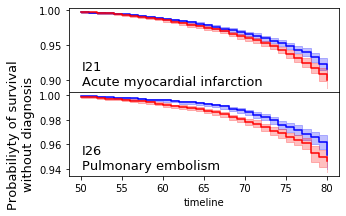

In [78]:
fig = plt.figure(figsize=(5.,5.))
gs = fig.add_gridspec(nrows=4,ncols=1,hspace=0.)
score_col = "adjusted_score" #"best_pval_score_homogenous"

for i, code in enumerate(["I21","I26"]):
    
    ax = fig.add_subplot(gs[i,0])
    
    events = all_ICD10_events.loc[all_ICD10_events.code == code]
    
    X_ = pd.merge(X[[BIRTH_FIELD,SEX_FIELD, DIABETES_FIELD,"AGE","SMOKING_RATE_bin","CHOLESTEROL_bin",score_col] + list(set(pc_covars_cols + pheno_cols))],events,left_index=True,right_on="ID",how="left").copy()
    X_["T"] = X_["AGE"].copy().astype(int)
    X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"].astype(int)
    #X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"]
    X_["EVENT"] = ~X_.AGE_AT_EVENT.isnull()*1
    X_ = X_.loc[X_["T"] >= 30]
    assert X_["T"].isnull().sum() == 0
    
    a = 0.05
    low = X_[score_col] < X_[score_col].quantile(a)
    high = X_[score_col] > X_[score_col].quantile(1-a)
    
    kmf_low = KaplanMeierFitter()
    kmf_low.fit(X_.loc[low,"T"],X_.loc[low,"EVENT"])
    kmf_low.plot_survival_function(loc=slice(50.,80.),label="Bottom %d%% of score" % int(100*a),legend=False,color="blue")

    kmf_high = KaplanMeierFitter()
    kmf_high.fit(X_.loc[high,"T"],X_.loc[high,"EVENT"])
    kmf_high.plot_survival_function(loc=slice(50.,80.),label="Top %d%% of score" % int(100*a),legend=False,color="red")
    
    if i == 0:
        plt.xlabel("Age (years)",fontsize=13)
    elif i == 1:
        plt.ylabel("Probabiliyty of survival\nwithout diagnosis",fontsize=13)
    else:
        plt.xticks([])
        plt.xlabel(None)
    plt.title(None)
    plt.text(x=0.05,y=0.08,s="%s\n%s" % (code,ICD10_sec_desc[code][4:]),transform = ax.transAxes,fontsize=13)
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/survival.pdf")
#plt.legend()
plt.savefig("/home/hv270/sysmex2pf/figures/survival_legend.pdf")

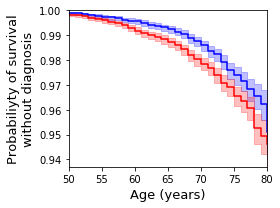

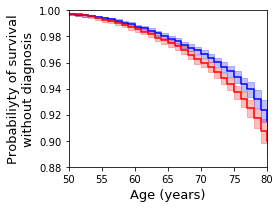

In [81]:
f = [0.063,0.12,0.44]
aspect_ratio = 3./4
import matplotlib.ticker as mtick
for i, code in enumerate(["I26","I21"]):
    
    fig, ax = plt.subplots(figsize=(4.,3.))
    
    events = all_ICD10_events.loc[all_ICD10_events.code == code]
    
    X_ = pd.merge(X[[BIRTH_FIELD,SEX_FIELD, DIABETES_FIELD,"AGE","SMOKING_RATE_bin","CHOLESTEROL_bin",score_col] + list(set(pc_covars_cols + pheno_cols))],events,left_index=True,right_on="ID",how="left").copy()
    X_["T"] = X_["AGE"].copy().astype(int)
    X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"].astype(int)
    #X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"]
    X_["EVENT"] = ~X_.AGE_AT_EVENT.isnull()*1
    X_ = X_.loc[X_["T"] >= 30]
    assert X_["T"].isnull().sum() == 0
    #ax.set_aspect(aspect_ratio*30/f[i])
    ax.set_ylim((1-f[i],1.))
    ax.set_xlim((50,80))
    
    a = 0.05
    low = X_[score_col] < X_[score_col].quantile(a)
    high = X_[score_col] > X_[score_col].quantile(1-a)
    
    kmf_low = KaplanMeierFitter()
    kmf_low.fit(X_.loc[low,"T"],X_.loc[low,"EVENT"])
    kmf_low.plot_survival_function(loc=slice(50.,80.),label="Bottom %d%% of score" % int(100*a),legend=False,color="blue")

    kmf_high = KaplanMeierFitter()
    kmf_high.fit(X_.loc[high,"T"],X_.loc[high,"EVENT"])
    kmf_high.plot_survival_function(loc=slice(50.,80.),label="Top %d%% of score" % int(100*a),legend=False,color="red")
    
    plt.xlabel("Age (years)",fontsize=13)
    plt.ylabel("Probabiliyty of survival\nwithout diagnosis",fontsize=13)
    
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    
    #plt.title(ICD10_sec_desc[code])
    #plt.text(x=0.05,y=0.08,s=ICD10_sec_desc[code],transform = ax.transAxes,fontsize=13)
    plt.tight_layout()
    plt.savefig("/home/hv270/sysmex2pf/figures/survival_%s.pdf" % code)
    #plt.legend()
    #plt.savefig("/home/hv270/sysmex2pf/figures/survival_%s_legend.pdf" % code)

In [125]:
np.argmin(np.abs(bins-np.quantile(X_[score_col],0.05)))

32

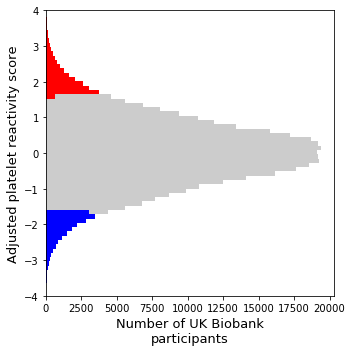

In [147]:
bins = np.linspace(X_[score_col].min(),X_[score_col].max(),85,endpoint=True)
#i_5 = np.argmin(np.abs(bins-np.quantile(X_[score_col],0.05)))
#i_95 = np.argmin(np.abs(bins-np.quantile(X_[score_col],0.95)))
#bins[i_5] = np.quantile(X_[score_col],0.05)
#bins[i_95] = np.quantile(X_[score_col],0.95)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
y_max = 8500
ax.set_ylim((0,y_max))
#ax.set_aspect(aspect_ratio*8/y_max)
ax.set_ylim((-4,4))
plt.hist(X_[score_col],bins=bins,color="gray",alpha=.4,orientation="horizontal");
plt.hist(X_.loc[low,score_col],bins=bins,color="blue",alpha=1,orientation="horizontal");
plt.hist(X_.loc[high,score_col],bins=bins,color="red",alpha=1,orientation="horizontal");
plt.ylabel("Adjusted platelet reactivity score",fontsize=13)
plt.xlabel("Number of UK Biobank\nparticipants",fontsize=13)
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/score_hist.pdf")

(-20000, 20000)

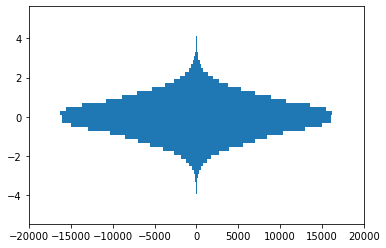

In [183]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim(-20000,20000)

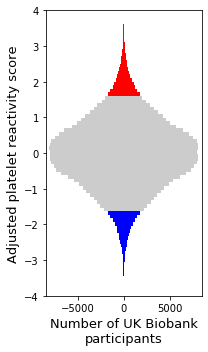

In [193]:
bins = np.linspace(X_[score_col].min(),X_[score_col].max(),101,endpoint=True)
b, c = np.histogram(X_[score_col],bins=50)

i_5 = np.argmin(np.abs(bins-np.quantile(X_[score_col],0.05)))
i_95 = np.argmin(np.abs(bins-np.quantile(X_[score_col],0.95)))
high_plot = X_[score_col] > bins[i_95]
low_plot = X_[score_col] < bins[i_5]

fig = plt.figure(figsize=(3,5))
ax = fig.add_subplot(111)
y_max = 8500
ax.set_xlim((-y_max,y_max))
#ax.set_aspect(aspect_ratio*8/y_max)
b, c = np.histogram(X_[score_col],bins=bins)
c_center = (c[1:]+c[:-1])/2
c_step = c[1]-c[0]
b_low, c = np.histogram(X_.loc[low_plot, score_col],bins=bins)
b_high, c = np.histogram(X_.loc[high_plot, score_col],bins=bins)

ax.set_ylim((-4,4))
ax.barh(y=c_center,width=b,height=c_step,left=-b/2,color="gray",alpha=.4)
ax.barh(y=c_center,width=b_low,height=c_step,left=-b_low/2,color="blue")
ax.barh(y=c_center,width=b_high,height=c_step,left=-b_high/2,color="red")
#plt.hist(X_[score_col],bins=bins,orientation="horizontal");
#plt.hist(X_.loc[low,score_col],bins=bins,color="blue",alpha=1,orientation="horizontal");
#plt.hist(X_.loc[high,score_col],bins=bins,color="red",alpha=1,orientation="horizontal");

plt.ylabel("Adjusted platelet reactivity score",fontsize=13)
plt.xlabel("Number of UK Biobank\nparticipants",fontsize=13)
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/score_hist.pdf")

Text(0, 0.5, 'Adjusted platelet reactivity score')

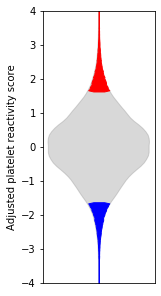

In [111]:
fig = plt.figure(figsize=(2,5))
ax = fig.add_subplot(111)
c = ax.violinplot(X_[score_col], showmeans=False,showextrema=False,widths=[2.4])
for pc in c['bodies']:
    pc.set_facecolor('grey')
    pc.set_edgecolor('grey')
c = ax.violinplot(X_.loc[low,score_col],showmeans=False,showextrema=False,bw_method=.03);
for pc in c['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('blue')
    pc.set_alpha(1)
c = ax.violinplot(X_.loc[high,score_col],showmeans=False,showextrema=False,bw_method=.03);
for pc in c['bodies']:
    pc.set_facecolor('red')
    pc.set_edgecolor('red')
    pc.set_alpha(1)
ax.set_ylim((-4,4))
ax.set_xticks([])
ax.set_ylabel("Adjusted platelet reactivity score")

# Unused

In [ ]:
gwas_results = pd.read_csv("/home/hv270/sysmex2pf/GWAS_table.csv",index_col=0)

In [ ]:
cox_and_GWAS = pd.merge(cox, gwas_results,left_on="SNP",right_on="SNP",how="left",suffixes=("_Cox","_GWAS"))\
    .rename(columns={"HR":"Hazard Ratio",
                     "corars":"Covariates used in Cox Regression",
                     "strata":"quartile (of # of cases)"})
cox_and_GWAS.to_csv("/home/hv270/sysmex2pf/GWAS_and_Cox.csv")

In [ ]:
per_SNP = cox.sort_values("P").groupby("SNP").first().sort_values("P")

In [ ]:
gwas_results.head(3)

In [ ]:
per_SNP = pd.merge(per_SNP,
         gwas_results[["SNP","CHR","BP","A1FREQ","was_in_NY_GWAS","PUBMED","SYMBOL","BETA"]],
         left_index=True,right_on="SNP",how="left")
per_SNP["isin_PUBMED"] = per_SNP.PUBMED != "-"

In [ ]:
per_SNP_export = per_SNP[["SNP","SYMBOL","P","desc","HR","BETA","covars","was_in_NY_GWAS","isin_PUBMED"]]\
    .rename(columns={"SYMBOL":"GENE (VEP selected)",
                     "P":"lowest P-value (Cox Regression)",
                     "HR":"hazard ratio",
                     "covars":"Covariates used"})

In [ ]:
per_SNP_export.to_csv("/home/hv270/sysmex2pf/cox_and_GWAS.csv")

In [ ]:
p = Pool(15)

for lt in tqdm(p.imap_unordered(compare_top_bottom, all_ICD10_events.groupby("code")),
              total=all_ICD10_events.code.nunique()):
    if lt is None: continue
    lt, desc = lt
    p_val = lt.summary["p"].iloc[0]
    if p_val < 1e-3:
        print(desc)
        print(lt.summary)
p.close()
p.join()

# Logistic regression

In [ ]:
pip install statsmodels

In [ ]:
from sklearn.linear_model import LogisticRegression
from statsmodels.api import GLM
from statsmodels.genmod import families

In [ ]:
for c in codes_to_focus_on:
    X[c] = X.index.isin(all_ICD10_events.loc[all_ICD10_events.code == c].ID.unique().tolist())

In [ ]:
X["anti_coag"] *= 1

In [ ]:
h1_cols = ["TOTAL_PFC","AGE"] #["AGE","thrombotic_event"]
h0_cols = ["AGE"] # ,"thrombotic_event"

for c in codes_to_focus_on:
    print(c)
    lr_just_score = GLM(X[c],X[["TOTAL_PFC","AGE"]], family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
    print(lr_just_score.summary())
    lr_thrombotic = GLM(X[c],X[["TOTAL_PFC","AGE","thrombotic_event"]], family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
    print(lr_thrombotic.summary())
    lr_anticoag = GLM(X[c],X[["TOTAL_PFC","AGE","anti_coag"]], family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
    print(lr_anticoag.summary())
    lr_anticoag = GLM(X[c],X[["TOTAL_PFC","AGE","anti_coag","thrombotic_event"]], family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
    print(lr_anticoag.summary())

In [ ]:
lr.coef_

In [ ]:
lr_null.coef_

# Simple Linear Regression

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:
def do_linear_test(args, phenos):
    
    code, events = args
    n_cases = events.shape[0]
    desc = ICD10_sec_desc["".join(code.split("."))]
    if n_cases <= min_n_cases: return None
    # get T column
    X_ = pd.merge(X[[BIRTH_FIELD,SEX_FIELD, DIABETES_FIELD,"AGE"] + list(set(all_basics_ + pc_covars_cols + pheno_cols))],events,left_index=True,right_on="ID",how="left").copy()
    X_["T"] = X_["AGE"].copy().astype(int)
    X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"].astype(int)
    #X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"]
    X_["EVENT"] = ~X_.AGE_AT_EVENT.isnull()*1
    assert X_["T"].isnull().sum() == 0
    
    #print(X_.loc[X_.EVENT > 0].head())
    
    #only_old_people = X_["T"] >= 18
    #if only_old_people.mean() < .6:
    #    print("Keeping %.2f for %s" % (only_old_people.mean(),desc))
    #X_ = X_.loc[only_old_people]
    
    
    # find if unisex
    n_cases = X_.EVENT.sum()
    valid_sexes = X_.loc[X_["EVENT"] > 0,SEX_FIELD].value_counts()
    valid_sexes = valid_sexes.loc[valid_sexes > (n_cases / 50)].index.tolist()
    unisex = len(valid_sexes) == 1
    if unisex:
        desc += " (unisex)"
    
    # Define people to include and strata
    to_include = X_[SEX_FIELD].isin(valid_sexes)
    strata = [SEX_FIELD] if not unisex else []
    strata += [DIABETES_FIELD]
        
    X_ = X_.loc[to_include]
    
    n_cases = X_.EVENT.sum()
    if n_cases <= min_n_cases: return None
    
    p_vals = []
    HRs = []
    c_group = []
    pheno = []
    
    cols_to_normalize = [c for c in X_.columns if X_[c].dtype == float and c != "EVENT"]
    cols_to_normalize += ["T","2443-0.0"]
    
    X_[cols_to_normalize] -= X_[cols_to_normalize].mean(axis=0)
    X_[cols_to_normalize] /= X_[cols_to_normalize].std(axis=0)
    
    for covars_group in basics_:
        basics = list(basics_[covars_group]) + ["T"]
        if not unisex:
            basics += [SEX_FIELD]
        

        cols_to_include_1 = basics #+ pc_covars_cols[:3]
        lm1 = LogisticRegression(penalty="none",solver="sag")
        lm1.fit(X_[cols_to_include_1],X_["EVENT"] > 0)
        
        LP = lm1.predict_log_proba(X_[cols_to_include_1])
        LL_without = np.sum(np.where(X_["EVENT"],LP[:,1],LP[:,0]))
        for s in phenos:
            cols_to_include_2 = cols_to_include_1 + [s]
            
            lm2 = LogisticRegression(penalty="none",solver="sag")
            lm2.fit(X_[cols_to_include_2], X_["EVENT"] > 0)

            LP = lm2.predict_log_proba(X_[cols_to_include_2])
            LL_with = np.sum(np.where(X_["EVENT"] > 0,LP[:,1],LP[:,0]))
            
            
            Delta_LL = LL_with-LL_without
            
            p_val = 1.-chi2(1).cdf(2*Delta_LL)

            ### cox_info.loc[code, "p"] = p_val
            HR = lm2.coef_[0,-1]
            ### cox_info.loc[code, "HR"] = HR
            
            p_vals.append(p_val)
            HRs.append(HR)
            c_group.append(covars_group)
            pheno.append(s)

            description = ""
            description += "| %s \t| %s : %.2f\t" % (s, covars_group,-np.log10(p_val))
            description += "%d cases \t %s \t %s" % (n_cases, code, desc)
            if p_val < 1e-3:
                print("==========================")
                print(description)
                print("==========================")
    
    return code, p_vals, n_cases, desc, HRs, c_group, pheno

In [ ]:
basics_ = {#"none":[],
           #"sysmex":pc_covars_cols[:3],
           #"environmental":["SMOKING_RATE",BMI_FIELD,CHOLESTEROL_FIELD],
           "all":pc_covars_cols[:3] + ["SMOKING_RATE",BMI_FIELD,DIABETES_FIELD,CHOLESTEROL_FIELD]}

In [ ]:
n_events = all_ICD10_events.code.value_counts()
large_events = n_events.loc[n_events >= min_n_cases].index.tolist()
cond = all_ICD10_events.code.isin(large_events)

In [ ]:
p = Pool(32)

codes_ = []
descs_ = []
n_cases_ = []
P_ = []
HR_ = []
phenos_ = []
covs_ = []

do_linear_test_pheno = partial(do_linear_test,phenos=pheno_cols)
for _ in tqdm(p.imap_unordered(do_linear_test_pheno, all_ICD10_events.loc[cond].groupby("code")),
              total=all_ICD10_events.loc[cond].code.nunique()):
    if _ is None: continue
    code, p_vals, n_cases, desc, HRs, covs, phenos = _
    for i in range(len(p_vals)):
        HR_.append(HRs[i])
        P_.append(p_vals[i])
        covs_.append(covs[i])
        codes_.append(code)
        descs_.append(desc)
        n_cases_.append(n_cases)
        phenos_.append(phenos[i])
p.close()
p.join()